In [109]:
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Activation
%matplotlib inline
from matplotlib import pyplot as plt

In [49]:
# Settings
input_pos = '../data/train_pos.txt'
input_neg = '../data/train_neg.txt'
input_embeddings = '../nn/glove.twitter.27B.100d.txt'
embeddings_dim = 100

In [6]:
# Creating vocabulary
def get_vocabulary(filename):
    vocabulary = []
    for line in tqdm(open(filename, 'r')):
        line = line.strip()
        for token in line.split():
            token = token.strip()
            vocabulary.append(token)
    return vocabulary

In [8]:
def join_vocabulary():
    return {x: i for i, x in enumerate(set(get_vocabulary(input_pos) + get_vocabulary(input_neg)))}

In [38]:
vocabulary = join_vocabulary(input_pos, input_neg)
vocabulary_size = len(vocabulary)
reverse_vocabulary = {y : x for x, y in vocabulary.items()}
print('Vocabulary size: %d words' % vocabulary_size)

100000it [00:00, 302207.67it/s]
100000it [00:00, 277056.94it/s]

Vocabulary size: 114427 words


In [20]:
def get_class(filename):
    tweets = []
    for line in tqdm(open(filename, 'r')):
        line = line.strip()
        tweet = []
        for token in line.split():
            token = token.strip()
            if token in vocabulary:
                tweet.append(vocabulary[token])
        if tweet: tweets.append(tweet)
    return tweets

In [39]:
class_pos = get_class(input_pos)
class_neg = get_class(input_neg)
print('Obtained %d positive and %d negative tweets' % (len(class_pos), len(class_neg)))

100000it [00:00, 100936.83it/s]
100000it [00:01, 85604.45it/s]

Obtained 100000 positive and 100000 negative tweets


In [58]:
embeddings = np.zeros((vocabulary_size, embeddings_dim))
for word_vector in tqdm(open(input_embeddings, 'r')):
    word, vector = word_vector.split(' ', 1)
    word = word.strip()
    vector = np.array(list(map(float, vector.split())))
    assert(vector.shape[0] == embeddings_dim)
    if word in vocabulary:
        embeddings[vocabulary[word]] = vector
print('Obtained embeddings for %.1f%% of words' % (np.mean(np.linalg.norm(embeddings, axis=1) > 0) * 100))

1193517it [00:36, 32530.40it/s]


In [86]:
def get_class_data(tweet_class):
    result = np.zeros((len(tweet_class), embeddings_dim))
    for i, tweet in tqdm(enumerate(tweet_class)):
        result[i] += np.sum(embeddings[tweet, :], axis=0)
    return result

In [87]:
pos_data = get_class_data(class_pos)
neg_data = get_class_data(class_neg)
print('Obtained mean embeddings')

100000it [00:01, 64071.90it/s]
100000it [00:01, 59529.38it/s]


In [99]:
X = np.vstack((neg_data, pos_data))
y = np.array([0] * neg_data.shape[0] + [1] * pos_data.shape[0]).reshape(-1, 1)

In [101]:
val_percent = 10
val_idx = np.random.choice(range(X.shape[0]), int(val_percent * 0.01 * X.shape[0]))
x_val = X[val_idx, :]
y_val = y[val_idx, :]
train_idx = np.setdiff1d(range(X.shape[0]), val_idx)
x_train = X[train_idx, :]
y_train = y[train_idx, :]

In [119]:
model = Sequential()
model.add(Dense(300, input_dim=embeddings_dim))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [123]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(x_train, y_train, epochs=200, batch_size=10000, validation_data = (x_val, y_val))

Train on 180934 samples, validate on 20000 samples
Epoch 1/200
180934/180934 [==============================] - 1s 7us/step - loss: 0.2427 - acc: 0.8909 - val_loss: 0.5965 - val_acc: 0.7982
Epoch 2/200
180934/180934 [==============================] - 1s 7us/step - loss: 0.2516 - acc: 0.8852 - val_loss: 0.5296 - val_acc: 0.7921
Epoch 3/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.2384 - acc: 0.8928 - val_loss: 0.5611 - val_acc: 0.8036
Epoch 4/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.2400 - acc: 0.8898 - val_loss: 0.5602 - val_acc: 0.7821
Epoch 5/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.2409 - acc: 0.8910 - val_loss: 0.5641 - val_acc: 0.7954
Epoch 6/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.2325 - acc: 0.8951 - val_loss: 0.6027 - val_acc: 0.7906
Epoch 7/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.2381 - acc: 0.8929 - val_lo

Epoch 59/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1420 - acc: 0.9404 - val_loss: 0.8288 - val_acc: 0.7527
Epoch 60/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1766 - acc: 0.9249 - val_loss: 0.7908 - val_acc: 0.7876
Epoch 61/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1653 - acc: 0.9295 - val_loss: 0.7318 - val_acc: 0.7783
Epoch 62/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1528 - acc: 0.9357 - val_loss: 0.8194 - val_acc: 0.7847
Epoch 63/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1507 - acc: 0.9355 - val_loss: 0.8316 - val_acc: 0.7695
Epoch 64/200
180934/180934 [==============================] - 2s 11us/step - loss: 0.1546 - acc: 0.9342 - val_loss: 0.7727 - val_acc: 0.7823
Epoch 65/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1363 - acc: 0.9446 - val_loss: 0.8638 - val_acc: 0.7914
Epoch 66/200


Epoch 117/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1204 - acc: 0.9525 - val_loss: 1.0638 - val_acc: 0.7856
Epoch 118/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1206 - acc: 0.9505 - val_loss: 1.0591 - val_acc: 0.7802
Epoch 119/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1376 - acc: 0.9469 - val_loss: 1.0199 - val_acc: 0.7842
Epoch 120/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.0853 - acc: 0.9670 - val_loss: 1.2181 - val_acc: 0.7501
Epoch 121/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1182 - acc: 0.9580 - val_loss: 1.1206 - val_acc: 0.7858
Epoch 122/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1122 - acc: 0.9544 - val_loss: 1.1198 - val_acc: 0.7845
Epoch 123/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1184 - acc: 0.9528 - val_loss: 1.0614 - val_acc: 0.7889
Epoch 

180934/180934 [==============================] - 2s 12us/step - loss: 0.0803 - acc: 0.9715 - val_loss: 1.1814 - val_acc: 0.7609
Epoch 175/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.0526 - acc: 0.9827 - val_loss: 1.2728 - val_acc: 0.7785
Epoch 176/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1031 - acc: 0.9620 - val_loss: 1.2778 - val_acc: 0.7849
Epoch 177/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.1162 - acc: 0.9580 - val_loss: 1.2350 - val_acc: 0.7841
Epoch 178/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.0714 - acc: 0.9764 - val_loss: 1.0805 - val_acc: 0.7729
Epoch 179/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.0550 - acc: 0.9823 - val_loss: 1.3722 - val_acc: 0.7864
Epoch 180/200
180934/180934 [==============================] - 2s 12us/step - loss: 0.0892 - acc: 0.9664 - val_loss: 1.3255 - val_acc: 0.7835
Epoch 181/200
180934

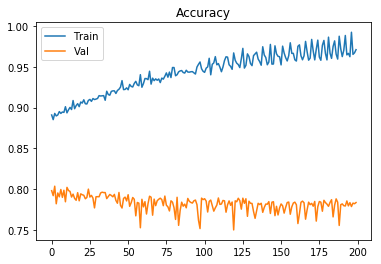

In [124]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.legend()
plt.show()